Libraries: The code imports various libraries required for data manipulation (numpy, pandas), data visualization (matplotlib, seaborn), and building the neural network (tensorflow, keras).

Data Preparation: Functions for loading the CIFAR-10 dataset and splitting the data into training and validation sets.

In [ ]:
!pip install tensorflow numpy pandas matplotlib

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
from matplotlib.patches import Circle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from matplotlib import cm
from sklearn.model_selection import train_test_split

In [ ]:
from keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model
%matplotlib inline

In [ ]:
print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.17.0


**Load Data:** CIFAR-10 consists of 60,000 32x32 color images across 10 classes. The data is split into training (80%) and validation (20%) datasets.

In [ ]:
# Download the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
#split the data into training and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
#print the shape of the data

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_train shape: (40000, 32, 32, 3)
y_train shape: (40000, 1)
x_val shape: (10000, 32, 32, 3)
y_val shape: (10000, 1)


Class Distribution: This code creates a bar plot to visualize the distribution of different classes in the training set.

In [ ]:
# CIFAR-10  classes as a list
label_list = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

<ipython-input-9-a5906a7a28b2>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Count', data=class_counts_df ,palette='pastel')


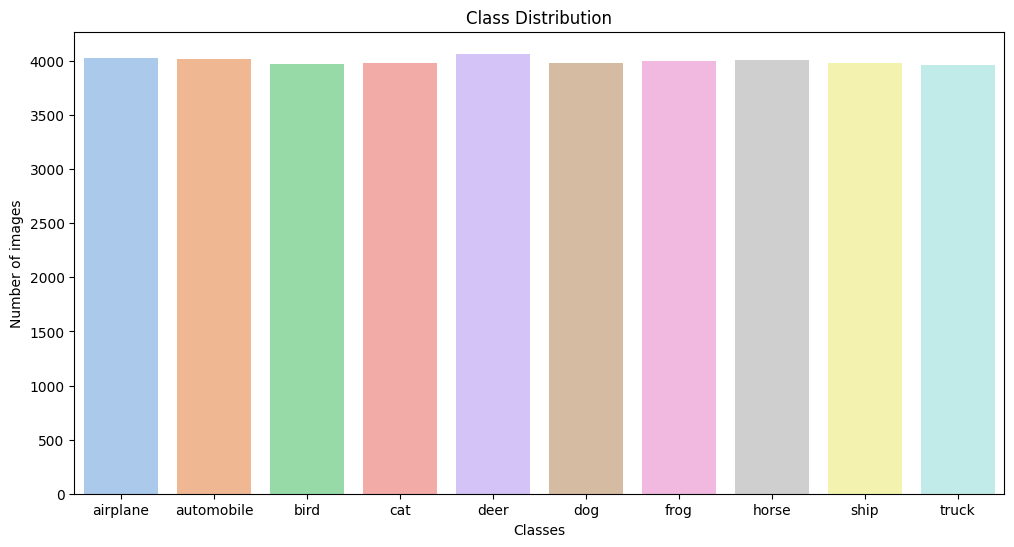

In [ ]:
# Class distribution
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(label_list, counts))

class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])


# Plot the class distribution of the training set
plt.figure(figsize=(12, 6))
sns.barplot(x='Class', y='Count', data=class_counts_df ,palette='pastel')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of images')
#plt.xticks(rotation=45)
plt.show()

In [ ]:
class_counts_df

,Class,Count
0,airplane,4027
1,automobile,4021
2,bird,3970
3,cat,3977
4,deer,4067
5,dog,3985
6,frog,4004
7,horse,4006
8,ship,3983
9,truck,3960


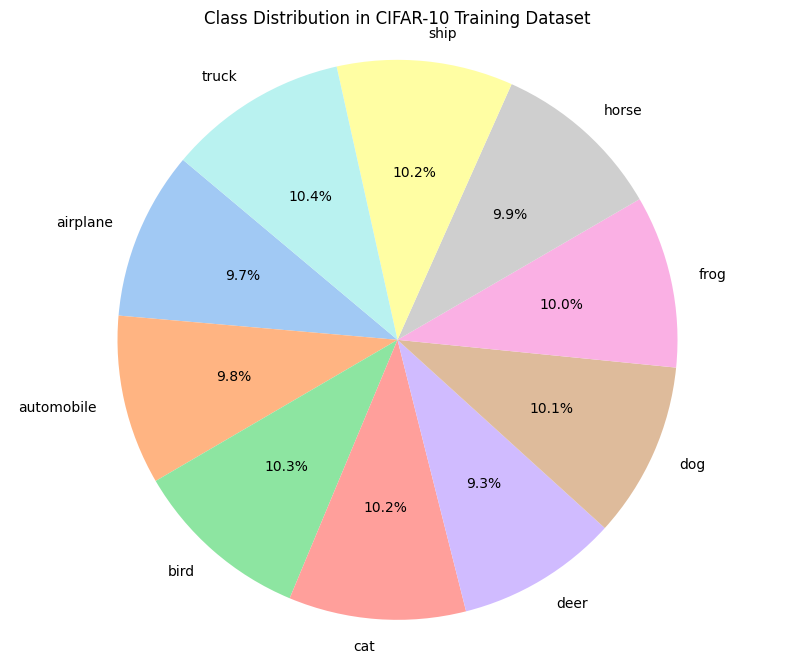

In [ ]:
unique, counts = np.unique(y_val, return_counts=True)
class_counts = dict(zip(label_list, counts))

class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])


# Plot the class distribution of the validation set
plt.figure(figsize=(10, 8))
plt.pie(class_counts_df['Count'], labels=class_counts_df['Class'],
        autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel', len(label_list)))

plt.title('Class Distribution in CIFAR-10 Training Dataset')
plt.axis('equal')
plt.show()

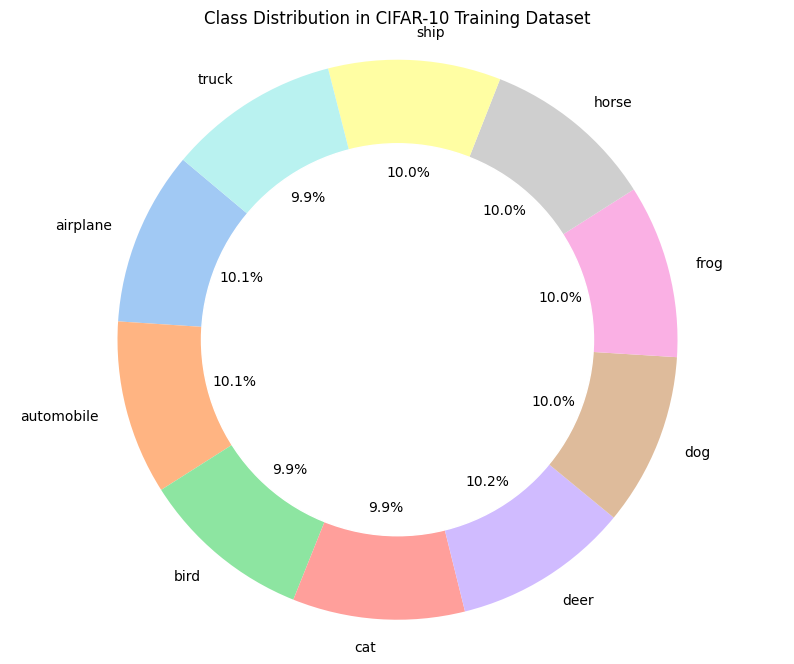

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(label_list, counts))

class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])


# Plot the class distribution of the training set

plt.figure(figsize=(10, 8))

wedges, texts, autotexts = plt.pie(class_counts_df['Count'], labels=class_counts_df['Class'],
                                   autopct='%1.1f%%', startangle=140,
                                   colors=sns.color_palette('pastel', len(label_list)))

circle = Circle((0, 0), 0.7, color='white')
plt.gca().add_artist(circle)

plt.axis('equal')
plt.title('Class Distribution in CIFAR-10 Training Dataset')
plt.show()

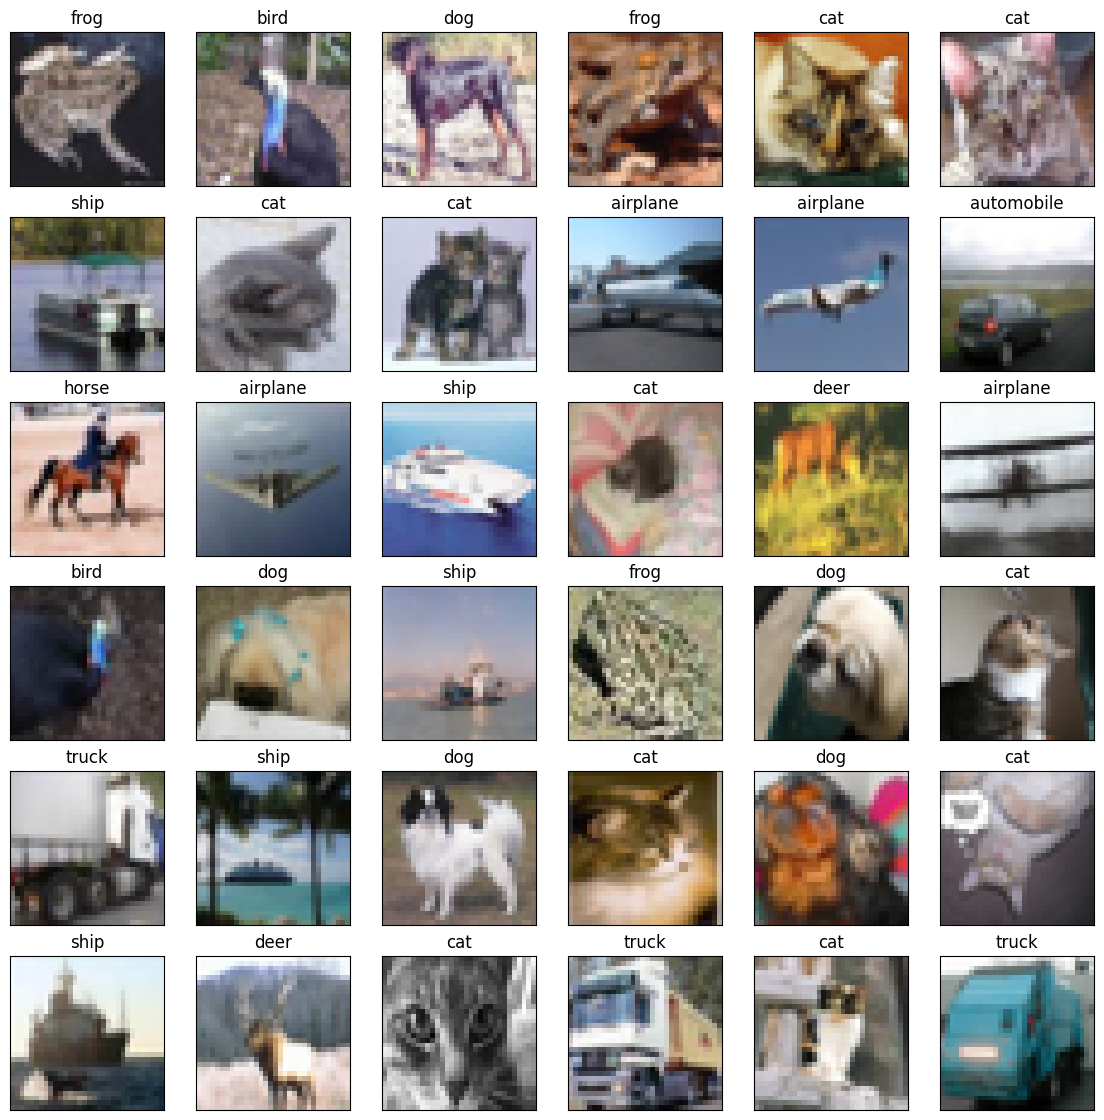

In [ ]:
# let's visualize some of the images in the dataset

fig, axes = plt.subplots(6, 6, figsize=(14, 14))

for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.title(label_list[y_train[i][0]])

plt.show()

In [ ]:
# pixel values to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')
mean = np.mean(x_train)
std = np.std(x_train)
print(mean)
print(std)

120.73008
64.074066


Normalization: Converts pixel values to float and normalizes the dataset by subtracting the mean and dividing by the standard deviation.

One-Hot Encoding: Converts class labels into one-hot encoded vectors.

In [ ]:
# Normalization
x_train = (x_train - mean) / (std+1e-7)
x_test = (x_test - mean) / (std+1e-7)
x_val = (x_val - mean) / (std+1e-7)
# Encoding the labels
# converting the class labels into one-hot vectors
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
y_val = to_categorical(y_val, 10)

Augmentation: Defines an image data generator to apply random transformations to the training data, enhancing the model's robustness.

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.3,
    brightness_range=[0.8,1.2],
    channel_shift_range=0.2
)
input_shape = x_train.shape[1:]

input_shape

(32, 32, 3)

Create the ZFNet model

Model Definition: The code constructs a ZFNet-like architecture using Keras' Sequential model. It includes multiple convolutional layers, max pooling layers, and fully connected layers.

Compilation: The model is compiled with the Adam optimizer and categorical cross-entropy loss.

1. Convolutional Layers (CL)

  Total Convolutional Layers: 5

  Layer 1: 96 filters of size 7x7

  Layer 2: 256 filters of size 5x5

  Layer 3: 384 filters of size 3x3

  Layer 4: 384 filters of size 3x3

  Layer 5: 256 filters of size 3x3


2. Max Pooling Layers (PL)

  Total Max Pooling Layers: 3

  After Layer 1

  After Layer 2

  After Layer 5



3. Fully Connected Layers (FCL)

  Total Fully Connected Layers: 3

  Layer 1: 4096 neurons

  Layer 2: 4096 neurons

  Output Layer: Typically 1000 neurons (for ImageNet classification)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from keras.optimizers import Adam

# Define the ZFNet-like architecture
model = Sequential([
    # First Convolutional Layer
    Conv2D(filters=96, kernel_size=(7, 7), strides=(2, 2), padding='same', input_shape=(224, 224, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),

    # Second Convolutional Layer
    Conv2D(filters=256, kernel_size=(5, 5), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),

    # Third Convolutional Layer
    Conv2D(filters=384, kernel_size=(3, 3), padding='same'),
    Activation('relu'),

    # Fourth Convolutional Layer
    Conv2D(filters=384, kernel_size=(3, 3), padding='same'),
    Activation('relu'),

    # Fifth Convolutional Layer
    Conv2D(filters=256, kernel_size=(3, 3), padding='same'),
    Activation('relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),

    # Flatten
    Flatten(),

    # First Fully Connected Layer
    Dense(4096, activation='relu'),

    # Second Fully Connected Layer
    Dense(4096, activation='relu'),

    # Third Fully Connected Layer
    Dense(4096, activation='relu'),

    # Output Layer
    Dense(1000, activation='softmax')  # Adjust the number of units based on your number of classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 96)      14208     
                                                                 
 activation (Activation)     (None, 112, 112, 96)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 55, 55, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 55, 55, 256)       614656    
                                                                 
 activation_1 (Activation)   (None, 55, 55, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 27, 27, 256)       0         
 g2D)                                                   

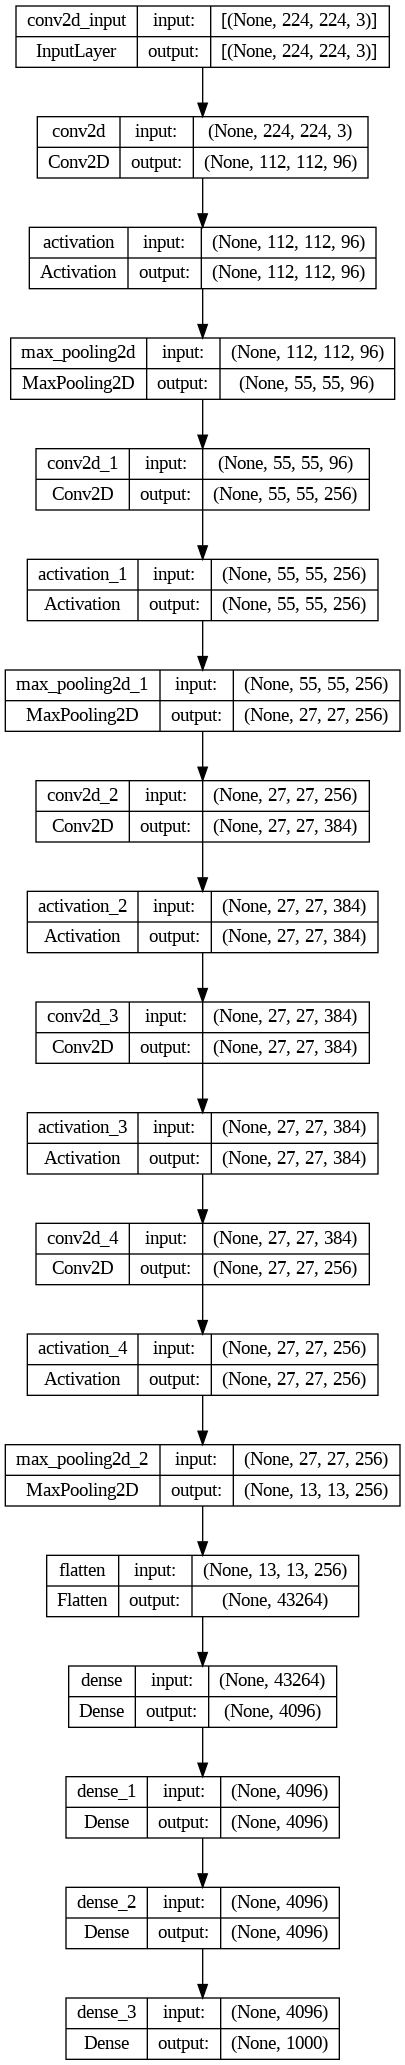

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='zfnet_model.png', show_shapes=True, show_layer_names=True,
            dpi=96, expand_nested=True)

Callbacks: Defines two callbacks: one for reducing the learning rate if validation loss does not improve and another for stopping training early if validation loss does not improve.

In [ ]:
# Learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10,
                               verbose=1, mode='auto', restore_best_weights=True)

In [ ]:
batch_size = 64
epochs = 5

steps_per_epoch=x_train.shape[0] // batch_size

steps_per_epoch # optimize this your ram OR Vram

625

In [ ]:
# Train the model

history = zfnet_model.fit(x_train, y_train,
                            steps_per_epoch=steps_per_epoch,
                            epochs=epochs,
                            validation_data=(x_val, y_val),
                            callbacks=[learning_rate_reduction, early_stopping],
                            verbose=1)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - accuracy: 0.2416 - loss: 1.9396 - val_accuracy: 0.4313 - val_loss: 1.5094 - learning_rate: 0.0010
Epoch 2/5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4313 - val_loss: 1.5094 - learning_rate: 0.0010
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.4557 - loss: 1.4623 - val_accuracy: 0.5275 - val_loss: 1.3043 - learning_rate: 0.0010
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5275 - val_loss: 1.3043 - learning_rate: 0.0010
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5263 - loss: 1.3019 - val_accuracy: 0.5413 - val_loss: 1.2399 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.


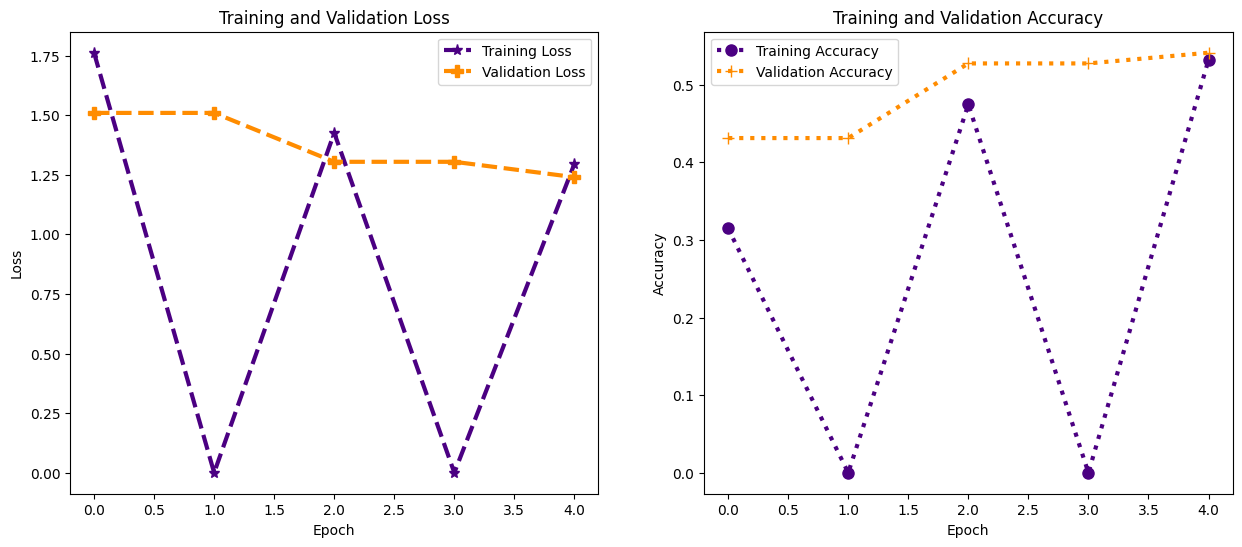

In [ ]:
plt.figure(figsize=(15,6))

# Plotting the training and validation loss

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss',
         color='indigo',marker="*",lw=3,markersize=8,linestyle="--")
plt.plot(history.history['val_loss'], label='Validation Loss',
         color='darkorange',marker="P",lw=3,markersize=8,linestyle="--")

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy',
         color='indigo',marker="o",lw=3,markersize=8,linestyle=":")
plt.plot(history.history['val_accuracy'], label='Validation Accuracy',
            color='darkorange',marker="+",lw=3,markersize=8,linestyle=":")

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.show()


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = zfnet_model.evaluate(x_test, y_test, verbose=1)

print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5552 - loss: 1.2242
Test loss: 1.2321429252624512
Test accuracy: 0.5529000163078308


In [ ]:
# Save the model
#zfnet_model.save('zfnet_model.h5') #old code
zfnet_model.save('zfnet_model.keras')
# predict the class of the test set
predictions = zfnet_model.predict(x_test)
final_pred = np.argmax(predictions, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


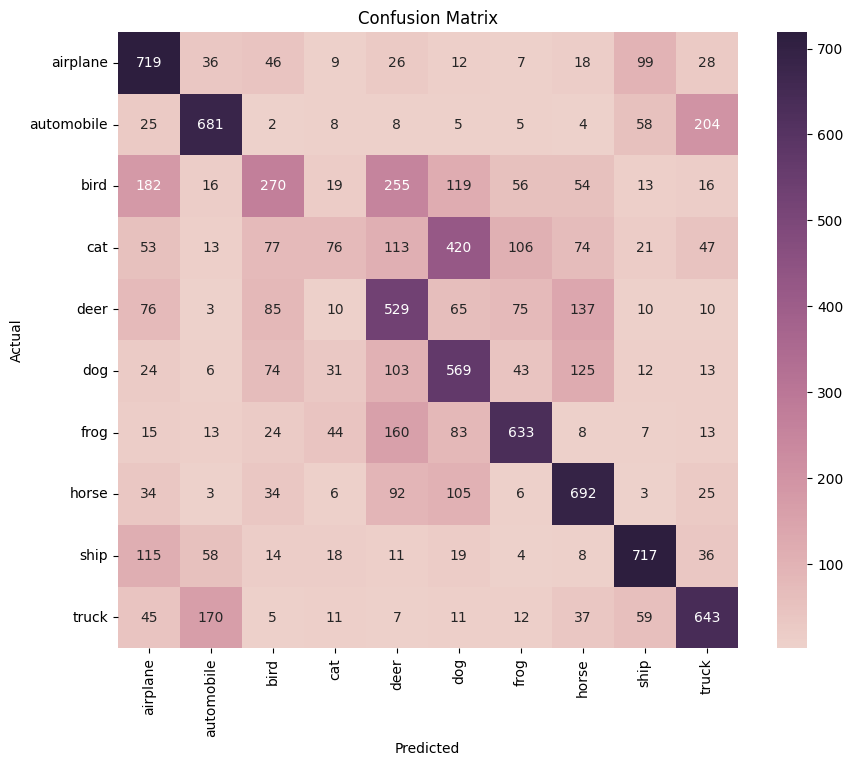

In [ ]:
from sklearn.metrics import (classification_report, confusion_matrix ,roc_curve,roc_auc_score, log_loss,
                             accuracy_score, precision_score, recall_score, f1_score,
                             cohen_kappa_score , matthews_corrcoef , brier_score_loss)
import seaborn as sns

confusion_matrix = confusion_matrix(y_test_labels, final_pred)

plt.figure(figsize=(10, 8))

sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True),
            xticklabels=label_list, yticklabels=label_list)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()

In [ ]:
# Classification report
print(classification_report(y_test_labels, final_pred, target_names=label_list))

              precision    recall  f1-score   support

    airplane       0.56      0.72      0.63      1000
  automobile       0.68      0.68      0.68      1000
        bird       0.43      0.27      0.33      1000
         cat       0.33      0.08      0.12      1000
        deer       0.41      0.53      0.46      1000
         dog       0.40      0.57      0.47      1000
        frog       0.67      0.63      0.65      1000
       horse       0.60      0.69      0.64      1000
        ship       0.72      0.72      0.72      1000
       truck       0.62      0.64      0.63      1000

    accuracy                           0.55     10000
   macro avg       0.54      0.55      0.53     10000
weighted avg       0.54      0.55      0.53     10000



In [ ]:
report = classification_report(y_test_labels, final_pred, target_names=label_list, output_dict=True)

report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
airplane,0.558230,0.7190,0.628497,1000.0000
automobile,0.681682,0.6810,0.681341,1000.0000
bird,0.427892,0.2700,0.331085,1000.0000
cat,0.327586,0.0760,0.123377,1000.0000
deer,0.405675,0.5290,0.459201,1000.0000
dog,0.404119,0.5690,0.472591,1000.0000
frog,0.668427,0.6330,0.650231,1000.0000
horse,0.598099,0.6920,0.641632,1000.0000
ship,0.717718,0.7170,0.717359,1000.0000
truck,0.621256,0.6430,0.631941,1000.0000


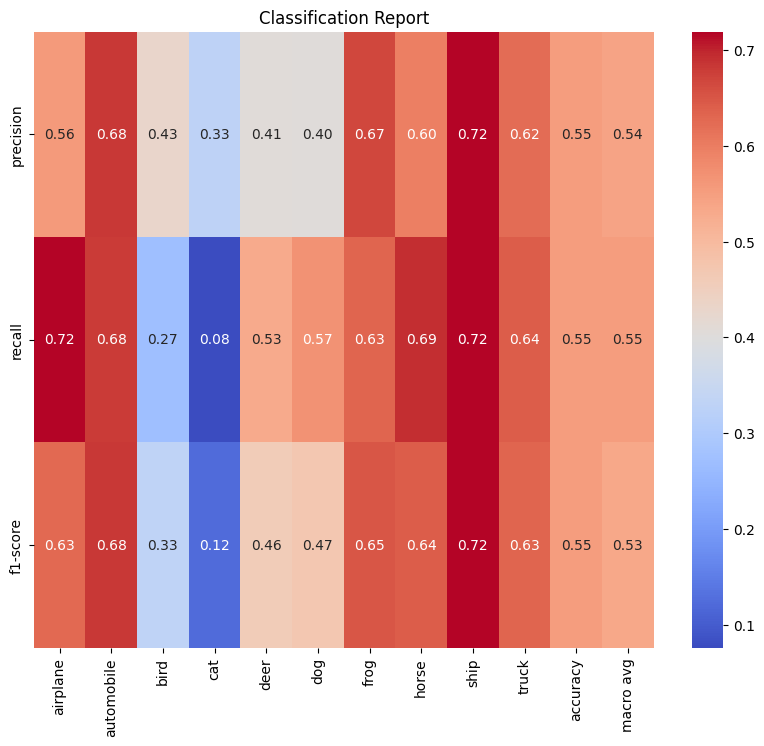

In [ ]:
# Plot the classification report
plt.figure(figsize=(10, 8))
sns.heatmap(report_df.iloc[:-1, :-1].T, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Classification Report')
plt.show()

In [ ]:
# Classification metrics definitions
# Accuracy
accuracy = accuracy_score(y_test_labels, final_pred)
# Precision
precision = precision_score(y_test_labels, final_pred, average='weighted')
# Recall
recall = recall_score(y_test_labels, final_pred, average='weighted')
# F1 score
f1 = f1_score(y_test_labels, final_pred, average='weighted')
# roc_auc_score
roc_auc = roc_auc_score(y_test, predictions, multi_class='ovr')
# cohen_kappa_score
cohen_kappa = cohen_kappa_score(y_test_labels, final_pred)
# matthews_corrcoef
mcc = matthews_corrcoef(y_test_labels, final_pred)

In [ ]:
# Print the classification metrics scores list

metrics_scores = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC Score': roc_auc,
    'Cohen Kappa Score': cohen_kappa,
    'Matthews Correlation Coefficient': mcc
}
# data frame of the metrics scores
metrics_scores_df = pd.DataFrame(list(metrics_scores.items()), columns=['Metric', 'Score'])

metrics_scores_df

,Metric,Score
0,Accuracy,0.552900
1,Precision,0.541068
2,Recall,0.552900
3,F1 Score,0.533725
4,ROC AUC Score,0.908419
5,Cohen Kappa Score,0.503222
6,Matthews Correlation Coefficient,0.506316


In [ ]:
# metrics scorces df each class
# Precision, Recall, F1 Score, Support
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []

for class_label in range(len(label_list)):
    class_report = classification_report(y_test_labels, final_pred, output_dict=True)
    accuracy_list.append(class_report[str(class_label)]['f1-score'])
    precision_list.append(class_report[str(class_label)]['precision'])
    recall_list.append(class_report[str(class_label)]['recall'])
    f1_list.append(class_report[str(class_label)]['f1-score'])

class_metrics_df = pd.DataFrame()
class_metrics_df['Class'] = label_list
class_metrics_df['Precision'] = precision_list
class_metrics_df['Recall'] = recall_list
class_metrics_df['F1 Score'] = f1_list

class_metrics_df

,Class,Precision,Recall,F1 Score
0,airplane,0.558230,0.719,0.628497
1,automobile,0.681682,0.681,0.681341
2,bird,0.427892,0.270,0.331085
3,cat,0.327586,0.076,0.123377
4,deer,0.405675,0.529,0.459201
5,dog,0.404119,0.569,0.472591
6,frog,0.668427,0.633,0.650231
7,horse,0.598099,0.692,0.641632
8,ship,0.717718,0.717,0.717359
9,truck,0.621256,0.643,0.631941


In [ ]:
num_classes = len(label_list)
# brier score loss each class df

brier_score_loss_list = []
brier_score_loss_df = pd.DataFrame()

for class_label in range(num_classes):
    class_mask = (y_test_labels == class_label)
    class_predictions = (final_pred == class_label)
    brier_score = brier_score_loss(class_mask, class_predictions)
    brier_score_loss_list.append(brier_score)

brier_score_loss_df['Class'] = label_list
brier_score_loss_df['Brier Score Loss'] = brier_score_loss_list

brier_score_loss_df

,Class,Brier Score Loss
0,airplane,0.0850
1,automobile,0.0637
2,bird,0.1091
3,cat,0.1080
4,deer,0.1246
5,dog,0.1270
6,frog,0.0681
7,horse,0.0773
8,ship,0.0565
9,truck,0.0749


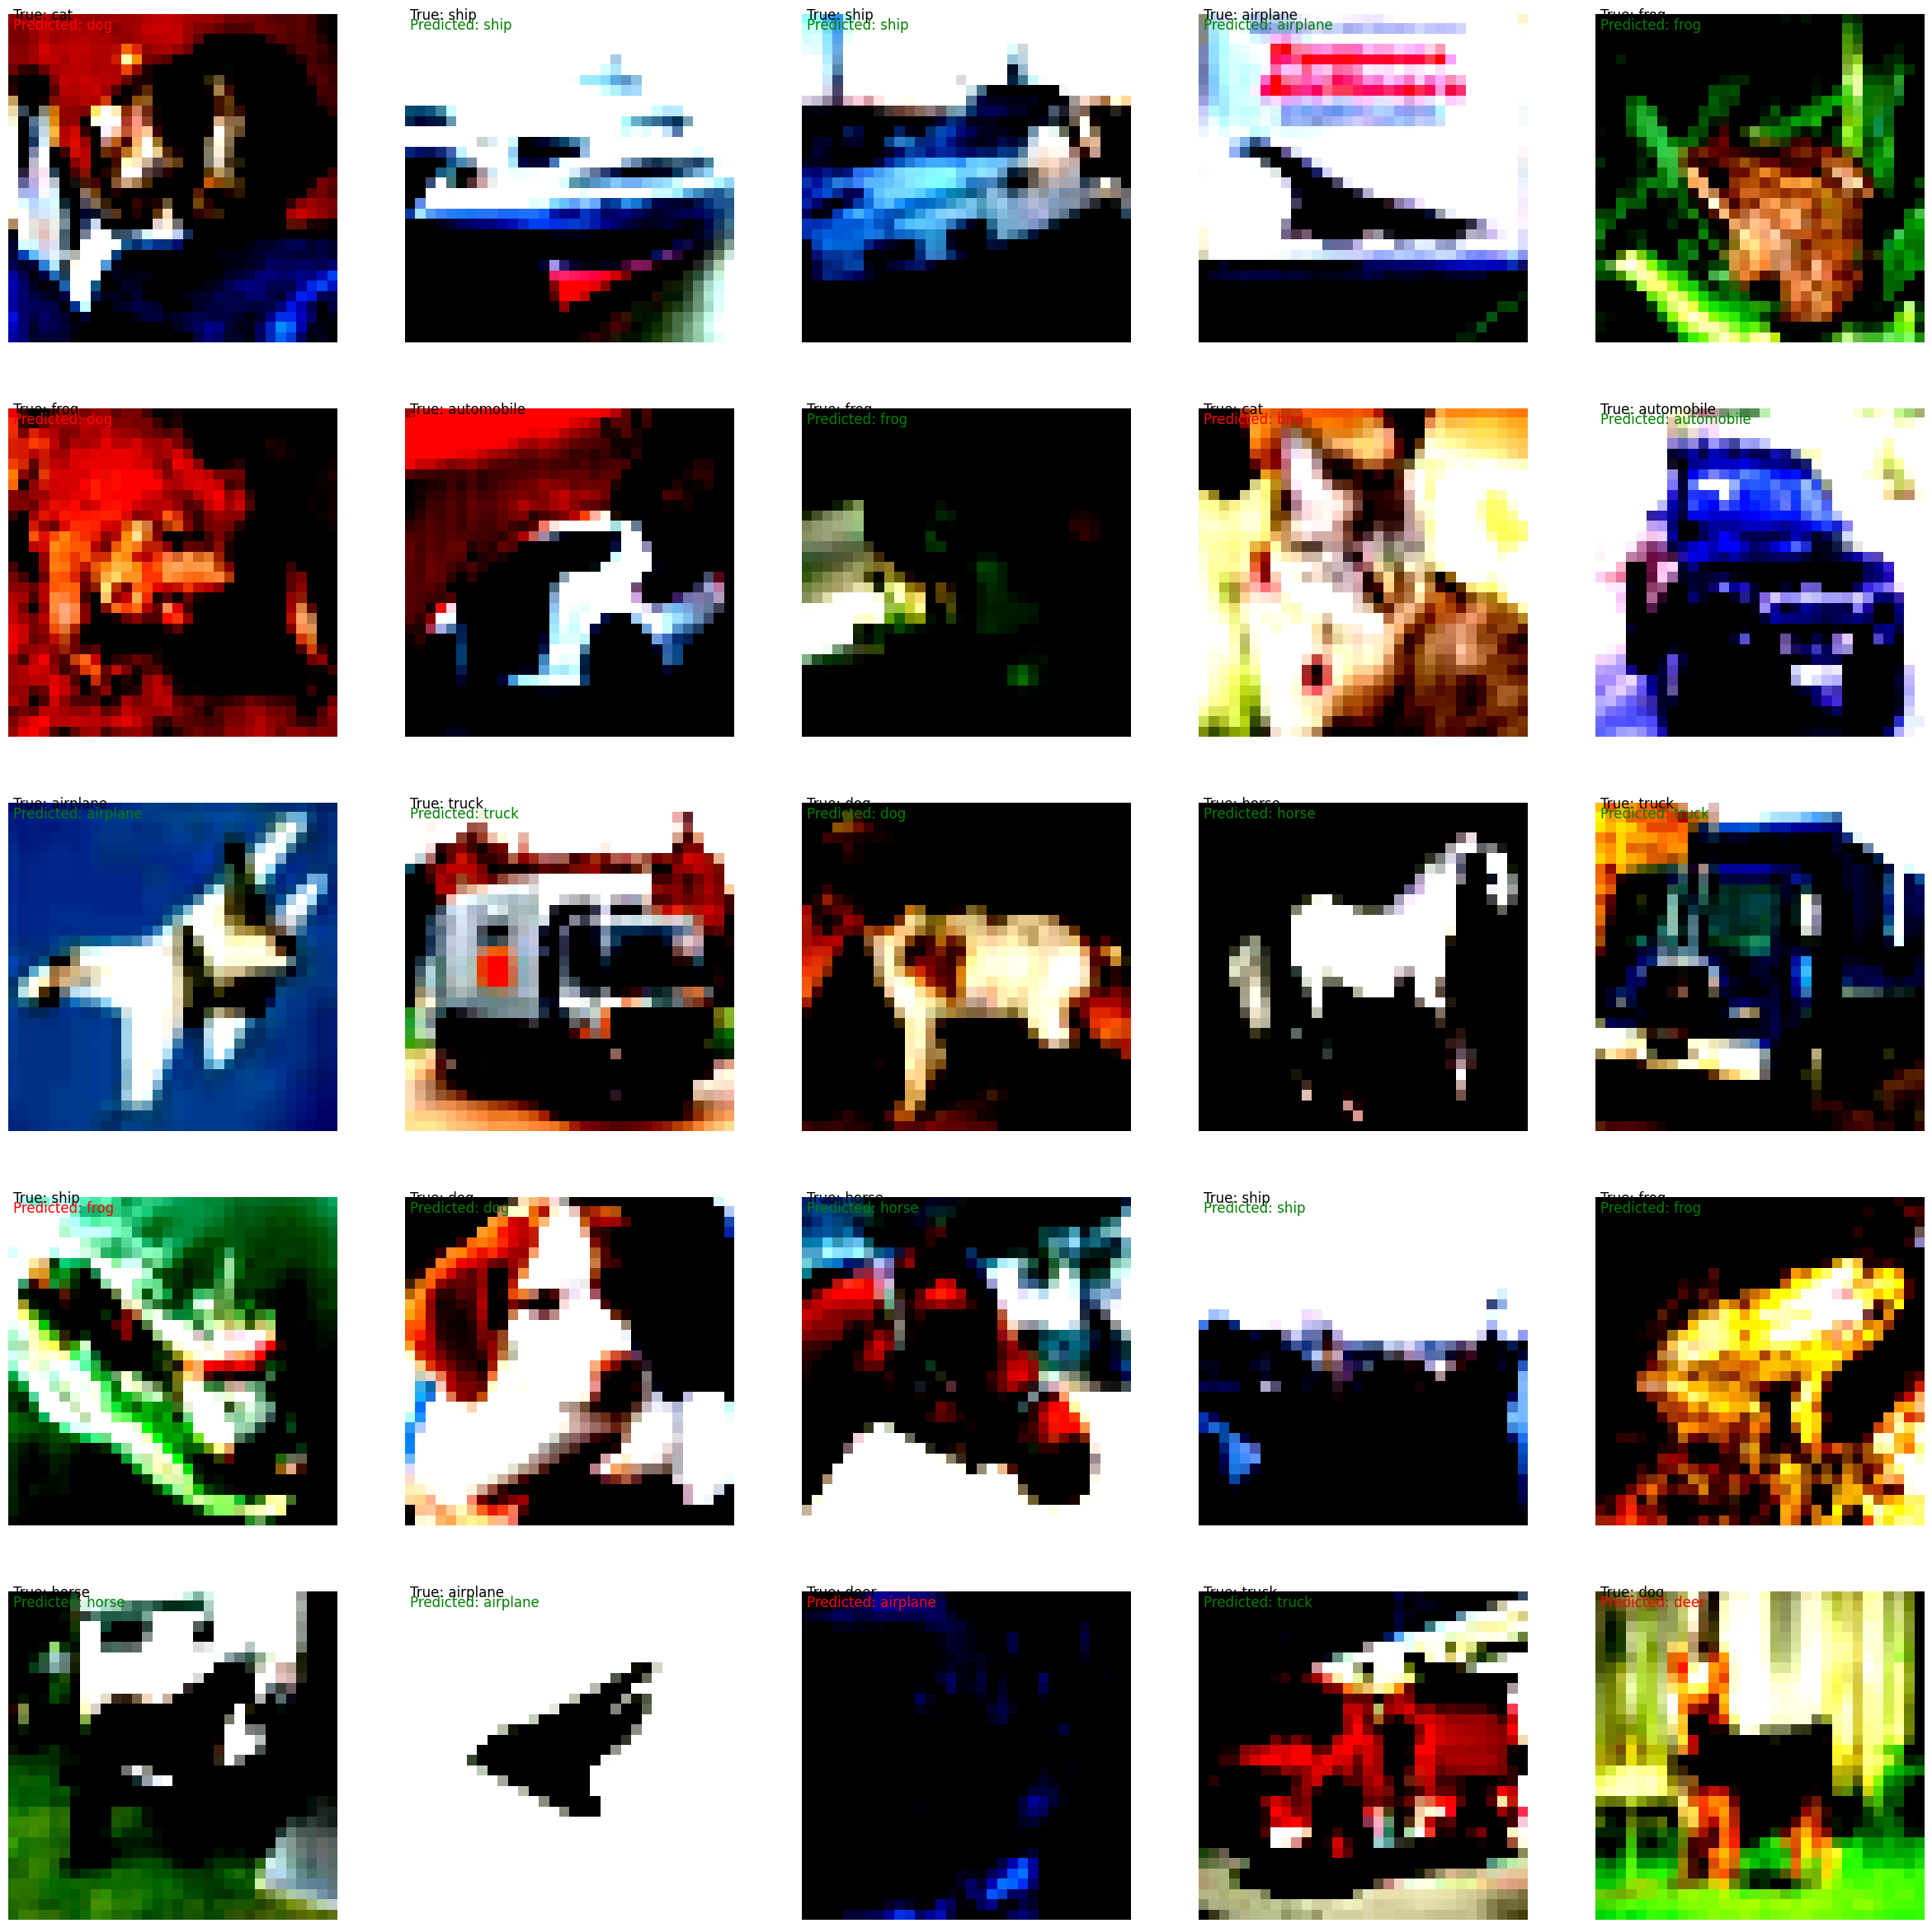

In [ ]:
plt.figure(figsize=(30, 30))

number_images = (5,5)

num_samples = min(number_images[0]*number_images[1], len(x_test))

for i in range(num_samples):
    plt.subplot(number_images[0], number_images[1], i+1)
    plt.axis('off')

    true_label = label_list[y_test_labels[i]]
    predicted_label = label_list[final_pred[i]]

    colors = 'green' if true_label == predicted_label else 'red'


    plt.text(0, 0, f'True: {true_label}', color='black', fontsize=12)
    plt.text(0, 1, f'Predicted: {predicted_label}', color=colors, fontsize=12)
    plt.imshow(x_test[i])

plt.show()


In [ ]:
plt.figure(figsize=(30, 30))

import  urllib.request
import os
from PIL import Image

img_url = "https://t3.ftcdn.net/jpg/00/41/06/42/360_F_41064239_IaGdGyf1vxHFaNDS5K164OFOwiMe1hC9.jpg"

# Retrieve the image from the URL
filename, headers = urllib.request.urlretrieve(img_url)
img_path = os.path.join(os.getcwd(), filename)
img = Image.open(img_path)
img = img.resize((32,32))
img = np.array(img) / 255.0
img = np.expand_dims(img, axis=0)

# Predict the class of the image
probs = zfnet_model.predict(img)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


<Figure size 3000x3000 with 0 Axes>

In [ ]:
# Get the predicted class index and name
pred_class_prob = np.argmax(probs)
pred_class_name = label_list[pred_class_prob]
max_prob = np.max(probs)
print(f'Predicted class: {pred_class_name}')
print(f'Maximum probability: {max_prob}')

Predicted class: ship
Maximum probability: 0.7359659075737


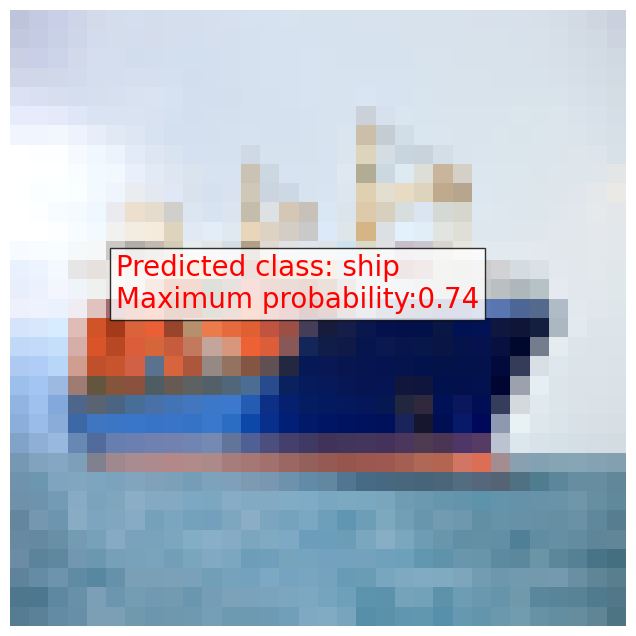

In [ ]:
# Display the image with the predicted class and probability
plt.figure(figsize=(10,8))
plt.imshow(img[0])
plt.axis('off')
plt.text(5, 15, f'Predicted class: {pred_class_name}\nMaximum probability:{max_prob:.2f}',
         fontsize=20, color='red', bbox=dict(facecolor='white',alpha=0.8))
plt.show()